In [1]:
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
import pm4py
import seaborn as sns
import math
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
def read_and_prep_dataset(file_path):
    # read dataset
    data_raw = pm4py.read_xes(file_path)
        
    # Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
    # the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
    # get more complete traces for our prediction
    data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']
    log = pm4py.convert_to_event_log(data_raw)
        
    # Only keep two most frequent traces, we believe these are the most complete traces
    filtered_log = pm4py.filter_end_activities(log, ['A_Pending','O_Cancelled'])
        
    df = pm4py.convert_to_dataframe(filtered_log)
    agg_dict = {"time:timestamp" :['min', 'max']}
    duration_df = pd.DataFrame(df.groupby("case:concept:name").agg(agg_dict)).reset_index()
    duration_df["trace_duration_days"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds() / (24 * 60 * 60)
    duration_df['trace_duration_days'] = duration_df['trace_duration_days'].apply(lambda x: math.ceil(x))
    duration_df["trace_duration_seconds"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds()
    duration_df.drop(columns=['time:timestamp'],inplace=True)
    duration_df = duration_df.droplevel(1, axis=1)

    df_with_duration = df.merge(duration_df, on='case:concept:name')
    #df_with_duration['sum_Time_sec'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.iloc[0]).dt.total_seconds()
    df_with_duration_remain = df_with_duration.copy()
    df_with_duration_remain['remaining_time_seconds'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds()
    df_with_duration_remain['remaining_time_days'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds() / (24 * 60 * 60)
    df_with_duration_remain['remaining_time_days'] = df_with_duration_remain['remaining_time_days'].apply(lambda x: math.ceil(x))
    
    
    #df_with_duration_remain['Complete_Timestamp'] = df_with_duration_remain.groupby('case:concept:name')['time:timestamp'].transform('last')
    #df_with_duration['duration'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds()
        
    return df_with_duration_remain
# Duration time, remaining_time cannot be used for testing, just for knowing data distribution

In [3]:
data = read_and_prep_dataset('BPI_Challenge_2017.xes.gz')

/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [4]:
data

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,FirstWithdrawalAmount,NumberOfTerms,Accepted,...,OfferedAmount,OfferID,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,trace_duration_days,trace_duration_seconds,remaining_time_seconds,remaining_time_days
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1144676.116,14
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1144676.068,14
2,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1144595.007,14
3,statechange,User_52,A_Accepted,Application,ApplState_99568828,complete,2016-01-02 11:23:04.299000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1052767.121,13
4,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,2016-01-02 11:29:03.994000+00:00,20000.0,44.0,True,...,20000.0,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1052407.426,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363341,statechange,User_96,O_Sent (mail and online),Offer,OfferState_1959881309,complete,2017-01-02 19:27:20.453000+00:00,NaN,NaN,NaN,...,NaN,Offer_1580299144,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,1175040.686,14
363342,Deleted,User_96,W_Complete application,Workflow,Workitem_22300685,complete,2017-01-02 19:27:20.465000+00:00,NaN,NaN,NaN,...,NaN,NaN,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,1175040.674,14
363343,statechange,User_96,A_Complete,Application,ApplState_1120616436,complete,2017-01-02 19:27:20.474000+00:00,NaN,NaN,NaN,...,NaN,NaN,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,1175040.665,14
363344,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,NaN,NaN,NaN,...,NaN,NaN,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,0.025,1


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


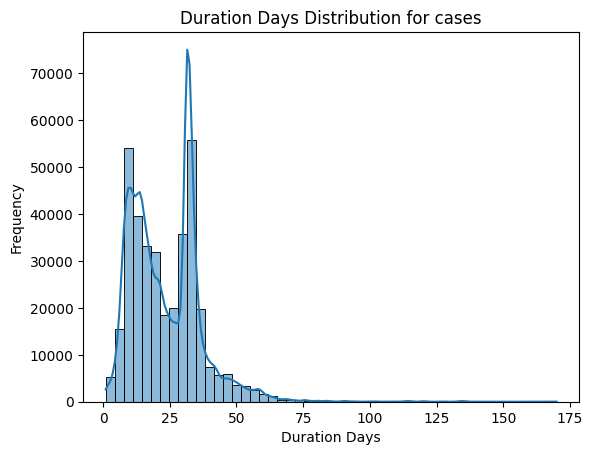

In [5]:
sns.histplot(data['trace_duration_days'],bins=50, kde=True)
plt.title('Duration Days Distribution for cases')
plt.xlabel('Duration Days')
plt.ylabel('Frequency')
plt.show()

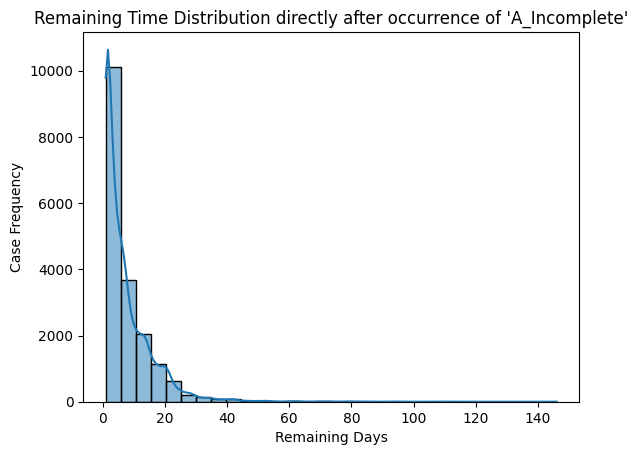

In [29]:

selected_rows_A_Incomplete = data[data['concept:name'] == 'A_Incomplete']



sns.histplot(selected_rows_A_Incomplete['remaining_time_days'], bins=30, kde=True)
plt.title('Remaining Time Distribution directly after occurrence of \'A_Incomplete\'')
plt.xlabel('Remaining Days')
plt.ylabel('Case Frequency')
plt.show()

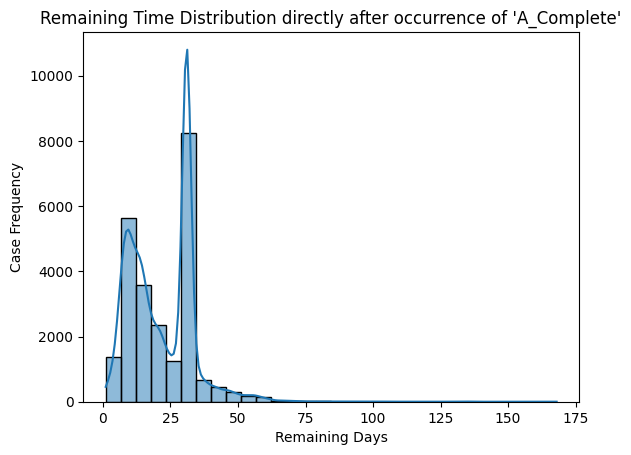

In [30]:

selected_rows_A_Complete = data[data['concept:name'] == 'A_Complete']



sns.histplot(selected_rows['remaining_time_days'], bins=30, kde=True)
plt.title('Remaining Time Distribution directly after occurrence of \'A_Complete\'')
plt.xlabel('Remaining Days')
plt.ylabel('Case Frequency')
plt.show()

In [448]:
def find_order_Event(act, df):
    # Extract cases containing the specified activity
    matching_cases = df[(df['concept:name'] == act)]['case:concept:name']

    # Filter rows that meet the condition
    result_df = df[df['case:concept:name'].isin(matching_cases)]

    # Sort the DataFrame by time and case
    result_df = result_df.sort_values(by=['case:concept:name', 'time:timestamp'])

    # Add order numbers for each occurrence of the specified activity
    result_df[f'{act}_Order'] = result_df[result_df['concept:name'] == act].groupby('case:concept:name').cumcount() + 1

    # Rename occurrences of the specified activity based on order number
    result_df['concept:name'] = result_df.apply(lambda row: f"{act}_{int(row[f'{act}_Order'])}" 
                                              if row['concept:name'] == act else row['concept:name'], 
                                              axis=1)

    # Drop the 'A_Incomplete_Order' column (if needed)
    result_df = result_df.drop(f'{act}_Order', axis=1)
    
    return result_df

In [449]:
df_A_Incomplete = find_order_Event('A_Incomplete',data)

In [450]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [457]:
def plot_distribution(df, act, rows, num):

    # Assume your DataFrame is df, 'remaining_time_days' represents remaining time, 'concept:name' represents activity
    # Replace 'remaining_time_days' and 'concept:name' with your actual column names

    # Select rows for the specified activity, ranging from 1 to num
    selected_rows = df[df['concept:name'].isin([f'{act}_{i}' for i in range(1, num+1)])]

    # Calculate the number of rows and columns
    cols = math.ceil(len(selected_rows['concept:name'].unique()) / rows)

    if cols == 1:
        # Use seaborn's distplot to plot the histogram and curve
        sns.histplot(data=selected_rows, x='remaining_time_days', bins=25, kde=True, color='red')
        plt.title(f'Remaining Time Distribution after the occurrence of {act}')
        plt.xlabel('Remaining Days')
        plt.ylabel('Case Frequency')

    else:
        # Get the range of x-axis for all subplots
        x_axis_range = selected_rows['remaining_time_days'].max()

        # Set up subplot layout
        fig, axes = plt.subplots(rows, cols, figsize=(13, 12))

        # Plot multiple subplots together and set the same x-axis range
        for i, (activity, group) in enumerate(selected_rows.groupby('concept:name')):
            ax = axes[i // cols, i % cols]
            sns.histplot(data=group, x='remaining_time_days', bins=25, kde=True, ax=ax, color='red', line_kws={'color': 'orange', 'linewidth': 3})
            text_dict = {0: 'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth', 5: 'sixth'}
            ax.set_title('Remaining Time Distribution after the ' + text_dict[i] + ' occurrence of ' + act)
            ax.set_xlabel('Remaining Days')
            ax.set_ylabel('Case Frequency')
            ax.set_xlim(0, x_axis_range)  # Set the same x-axis range

    # Adjust layout
    plt.tight_layout()
    plt.show()


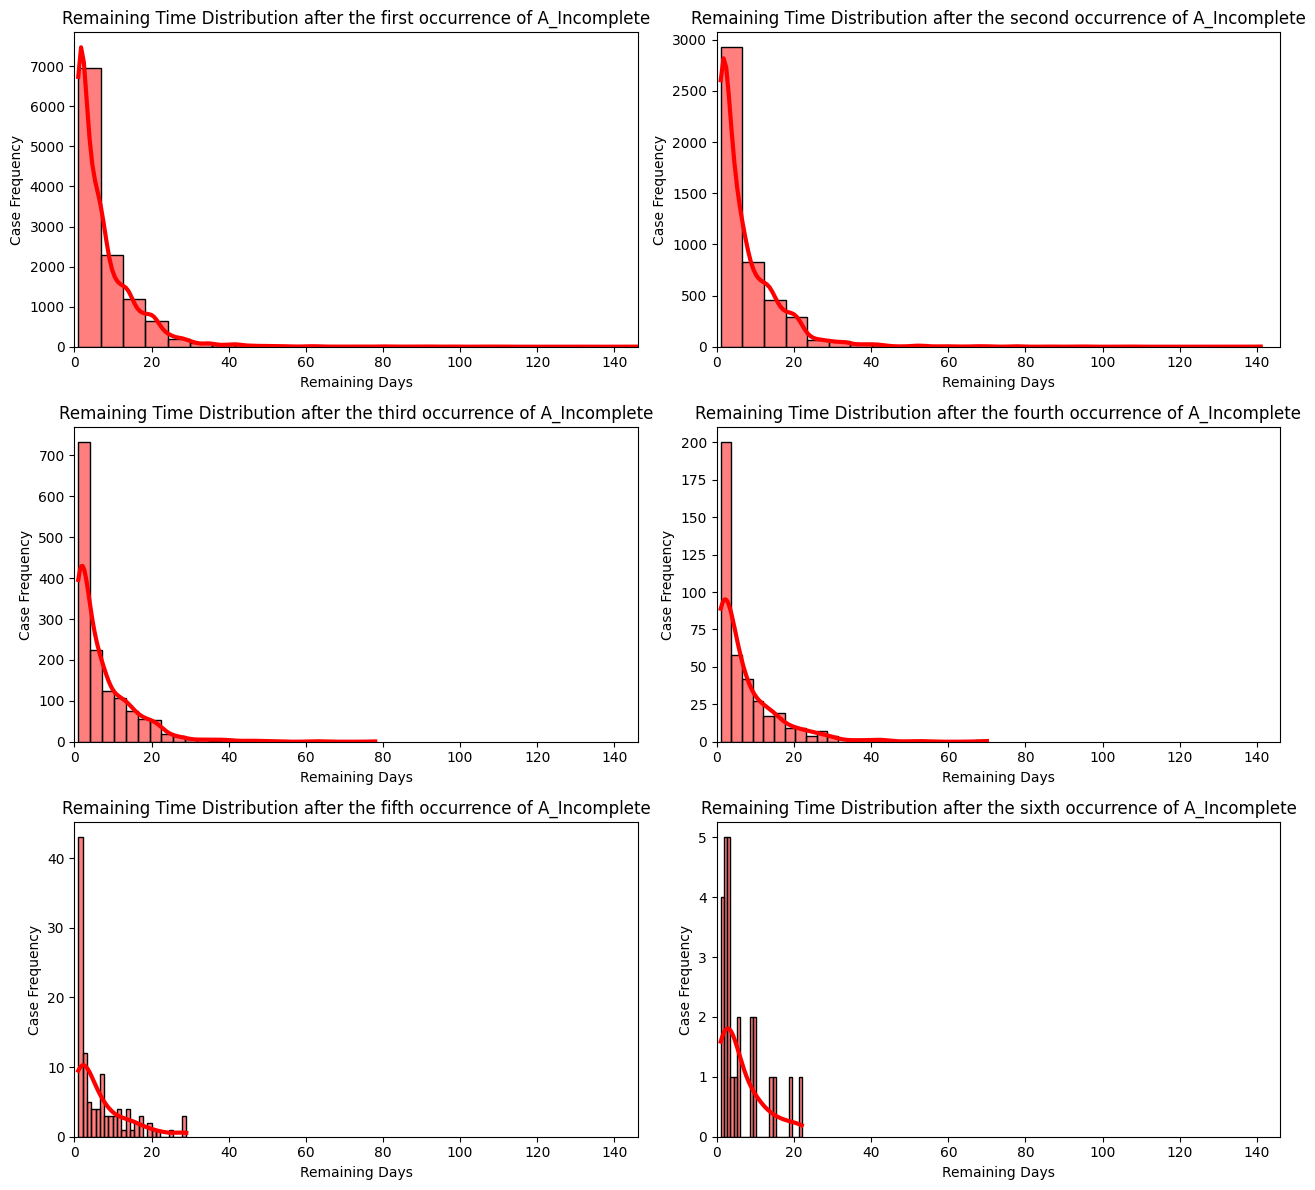

In [458]:
plot_distribution(df_A_Incomplete,'A_Incomplete',3,6)

In [459]:
df_A_Complete = find_order_Event('A_Complete',data)

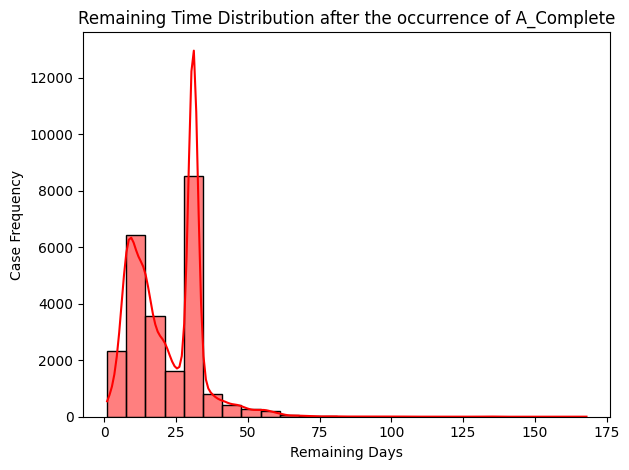

In [460]:
plot_distribution(df_A_Complete,'A_Complete',1,1)

In [461]:
df_O_Returned = find_order_Event('O_Returned',data)

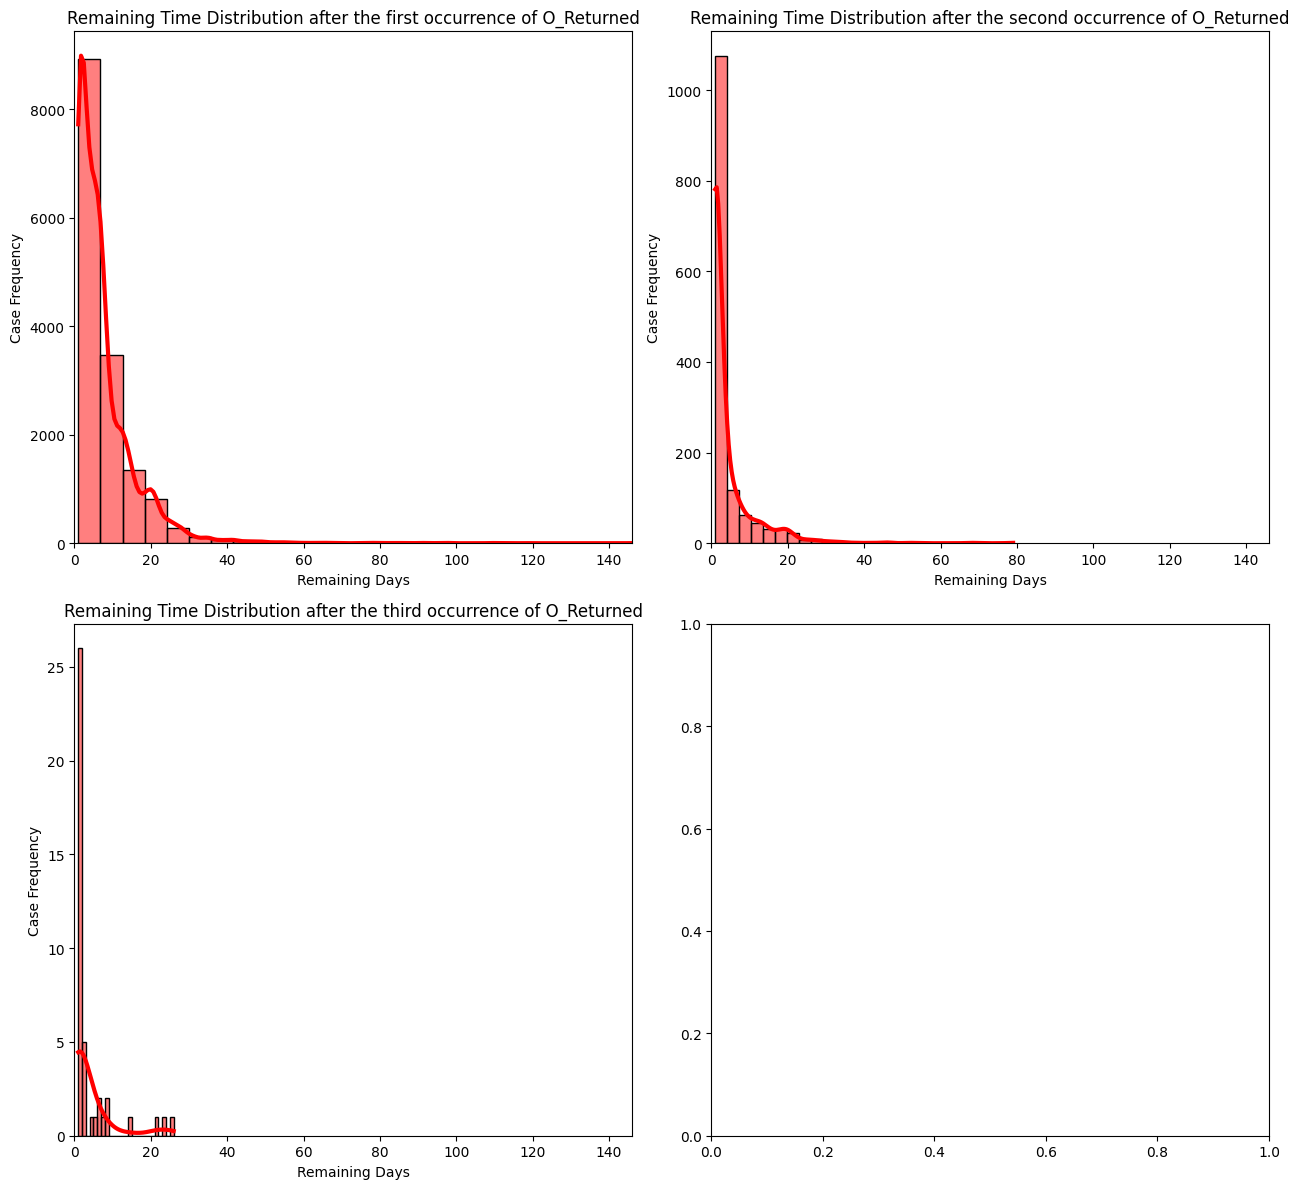

In [462]:
plot_distribution(df_O_Returned,'O_Returned',2,3)

# Feature Selection and Encoding

In [303]:
all_act=['concept:name_A_Create Application', 'concept:name_A_Submitted', 'concept:name_A_Concept', 'concept:name_A_Accepted',
       'concept:name_O_Create Offer', 'concept:name_O_Created', 'concept:name_O_Sent (mail and online)',
       'concept:name_A_Complete', 'concept:name_A_Validating', 'concept:name_O_Returned', 'concept:name_A_Incomplete',
       'concept:name_O_Accepted', 'concept:name_A_Pending', 'concept:name_W_Complete application', 'concept:name_O_Cancelled',
       'concept:name_W_Handle leads', 'concept:name_W_Validate application', 'concept:name_A_Cancelled',
       'concept:name_O_Sent (online only)', 'concept:name_W_Call incomplete files',
       'concept:name_W_Call after offers', 'concept:name_W_Assess potential fraud']

In [304]:
case_id_col = 'case:concept:name'
y_col = 'remaining_time_seconds'
dynamic_cat_cols = ['concept:name','Action','Selected','Accepted','org:resource']
static_cat_cols = ['case:LoanGoal']
dynamic_num_cols = ['FirstWithdrawalAmount','NumberOfTerms',
                                 'OfferedAmount','MonthlyCost']
static_num_cols = ['case:RequestedAmount']

# cat_cols = dynamic_cat_cols + static_cat_cols
# num_cols = dynamic_num_cols + static_num_cols

In [306]:
df_static = data[static_cat_cols + static_num_cols + ['case:concept:name']].drop_duplicates(keep='last')

In [307]:
def AggregateTransformer(X, case_id_col, num_cols, cat_cols, all_activities):
    # Ensure concept:name is in cat_cols for dummy variable creation
    if 'concept:name' not in cat_cols:
        cat_cols.append('concept:name')

    # Transform numeric columns
    dt_numeric = pd.DataFrame()
    if len(num_cols) > 0:
        dt_numeric = X.groupby(case_id_col)[num_cols].agg(["mean", "max", "min", "sum"])
        dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]

    # Transform categorical columns - creating dummy variables
    dt_cat = pd.get_dummies(X[cat_cols])
    dt_cat[case_id_col] = X[case_id_col]

    # Group by case_id_col and sum to get count of each activity per case
    dt_cat_grouped = dt_cat.groupby(case_id_col).sum()

    # Add missing activity columns with 0 values
    missing_activities = set(all_activities) - set(dt_cat_grouped.columns)
    for activity in missing_activities:
        dt_cat_grouped[activity] = 0

    # Concatenate numeric and categorical data
    dt_transformed = pd.concat([dt_cat_grouped, dt_numeric], axis=1)

    # Fill missing values with 0
    dt_transformed.fillna(0, inplace=True)
    
    return dt_transformed

# Bucketing and Prediction

In [308]:
data.drop(columns=['trace_duration_seconds','trace_duration_days'],inplace=True)

In [310]:
train_df, test_df = pm4py.split_train_test(data, train_percentage=0.75)

In [463]:
def get_bucket(act, df, num):
    # Sort the DataFrame by time and case
    df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

    # Find the first indices where 'act_num' appears in each case
    first_indices = df[df['concept:name'] == f'{act}_{num}'].groupby('case:concept:name').head(1).index

    # Process each case
    result_dfs = []
    for case_name, case_group in df.groupby('case:concept:name'):
        # Find the first index where 'act_num' appears in the current case
        current_case_first_index = first_indices[first_indices.isin(case_group.index)]

        # Create a boolean mask identifying rows in the current case before the first occurrence of 'act_num'
        keep_rows_mask = case_group.index <= current_case_first_index.min()

        # Use the mask to filter out the rows to be kept and add them to the result set
        result_df = case_group[keep_rows_mask]
        result_dfs.append(result_df)

    # Concatenate the result set into a single DataFrame
    result_df = pd.concat(result_dfs)

    return result_df


In [464]:
#function to get labels ready
def get_y(df_y, case_id_col):
 
    df_= df_y.groupby(case_id_col)['remaining_time_days'].last().reset_index()
    Y=df_['remaining_time_days']

    return Y

In [465]:
#get bucket for A_Incomplete_1

bucket_train_A_Incomplete = get_bucket('A_Incomplete',find_order_Event('A_Incomplete',train_df),1)
bucket_test_A_Incomplete = get_bucket('A_Incomplete',find_order_Event('A_Incomplete',test_df),1)

In [466]:
bucket_train_A_Incomplete_encoded = AggregateTransformer(bucket_train_A_Incomplete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)
bucket_test_A_Incomplete_encoded = AggregateTransformer(bucket_test_A_Incomplete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

In [467]:
#get bucket for A_Complete
bucket_train_A_Complete = get_bucket('A_Complete',find_order_Event('A_Complete',train_df),1)
bucket_test_A_Complete = get_bucket('A_Complete',find_order_Event('A_Complete',test_df),1)

In [468]:
bucket_train_A_Complete_encoded = AggregateTransformer(bucket_train_A_Complete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)
bucket_test_A_Complete_encoded = AggregateTransformer(bucket_test_A_Complete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

### Every trace only have one A_Complete

In [469]:
#get bucket for O_Returned_1
bucket_train_O_Returned = get_bucket('O_Returned',find_order_Event('O_Returned',train_df),1)
bucket_test_O_Returned = get_bucket('O_Returned',find_order_Event('O_Returned',test_df),1)

### Change 1 to 2 or 3 can get buckets maintaing until the second, third occurence of O_Returned

In [470]:
bucket_train_O_Returned_encoded = AggregateTransformer(bucket_train_O_Returned,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)
bucket_test_O_Returned_encoded = AggregateTransformer(bucket_test_O_Returned,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

In [471]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [472]:
def get_train_test_bucket(train,test,train_encoded,test_encoded):
        
    df_train = pd.DataFrame(train_encoded)
    df_train = pd.merge(df_train, df_static, how='left',on='case:concept:name').drop(columns=['case:concept:name'])
    string_columns = df_train.select_dtypes(include=['object']).columns
    df_train_encoded = pd.get_dummies(df_train, columns=string_columns)

    Y_train = get_y(train,case_id_col)

    df_test = pd.DataFrame(test_encoded)
    df_test = pd.merge(df_test, df_static, how='left',on='case:concept:name').drop(columns=['case:concept:name'])
    df_test_encoded = pd.get_dummies(df_test, columns=string_columns)

    intersection = list(set(df_train_encoded.columns).intersection(df_test_encoded.columns))
    df_train_encoded = df_train_encoded[intersection]
    df_test_encoded = df_test_encoded[intersection]

    Y_test = get_y(test, case_id_col)
    
    return df_train_encoded, df_test_encoded, Y_train, Y_test

In [473]:
df_train_encoded, df_test_encoded, Y_train, Y_test = get_train_test_bucket(bucket_train_O_Returned,
                                                                           bucket_test_O_Returned,
                                                                          bucket_train_O_Returned_encoded,
                                                                          bucket_test_O_Returned_encoded)

# Try for other buckets